In [52]:
# Force validation split for plotting
SPLIT = 'val'
print('Overriding SPLIT ->', SPLIT)


Overriding SPLIT -> val


# 05 – Results Visualization

This notebook compiles metrics and variant-effect outputs into publication-ready figures saved under `results/plots/`.

**Inputs (from 03–04):**
- `results/metrics.csv`
- `results/vep/summary.csv`
- `results/vep/deltas_<split>.npz`
- `results/vep/top50_<split>.tsv`

**Outputs:**
- `results/plots/metrics_bar_auroc.png`
- `results/plots/metrics_bar_prauc.png`
- `results/plots/vep_heatmap_<split>.png`
- `results/plots/topk_bar_<split>.png`
- `results/plots/vep_summary_table_<split>.csv`

## 0) Setup & paths

In [42]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def find_input_results_dir():
    # For inputs, prefer the location that already contains data (top-level or notebooks/results)
    candidates = [Path('results'), Path('notebooks') / 'results']
    for p in candidates:
        if p.exists():
            return p
    return candidates[0]
# INPUT_RESULTS is used to read existing artifacts (metrics.csv, vep/).
INPUT_RESULTS = find_input_results_dir()
# OUTPUT_RESULTS is always the top-level results/ directory where we write plots/manifests.
OUTPUT_RESULTS = Path('results')
OUTPUT_RESULTS.mkdir(parents=True, exist_ok=True)
PLOTS = OUTPUT_RESULTS / 'plots'
PLOTS.mkdir(parents=True, exist_ok=True)

# VEP reading: prefer vep under INPUT_RESULTS, but fall back to OUTPUT_RESULTS/vep if needed
VEP = INPUT_RESULTS / 'vep'
if not VEP.exists():
    alt = OUTPUT_RESULTS / 'vep'
    if alt.exists():
        VEP = alt

# For backwards compatibility some notebooks wrote into notebooks/results/. Use INPUT_RESULTS for reading
RESULTS = INPUT_RESULTS
SPLIT = 'test'  # change to 'val' or 'train'
print(f'Inputs read from: {INPUT_RESULTS}  |  Outputs written to: {OUTPUT_RESULTS}  |  VEP read from: {VEP}')

Inputs read from: results  |  Outputs written to: results  |  VEP read from: results/vep


## 1) Load metrics.csv → AUROC/PR-AUC bars

In [55]:
# Parameters, robust parsing, improved plotting and VEP checks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import warnings, re

# --- Parameters (override at top of notebook if desired) ---
RESULTS = Path("results")
# auto-detect input results if notebooks/results exists
if (Path('notebooks') / 'results').exists() and not (Path('results') / 'metrics.csv').exists():
    INPUT_RESULTS = Path('notebooks') / 'results'
else:
    INPUT_RESULTS = Path('results')
OUTPUT_RESULTS = RESULTS
PLOTS = OUTPUT_RESULTS / 'plots'
PLOTS.mkdir(parents=True, exist_ok=True)
VEP = INPUT_RESULTS / 'vep'
SPLIT = globals().get('SPLIT', 'val')  # use externally-set SPLIT if present, otherwise default to 'val'

print('\n--- IO Diagnostic ---')
print('RESULTS:', RESULTS)
print('INPUT_RESULTS:', INPUT_RESULTS)
print('OUTPUT_RESULTS:', OUTPUT_RESULTS)
print('PLOTS:', PLOTS)
print('VEP:', VEP)
print('SPLIT:', SPLIT)

# --- Utilities for robust parsing ---

def _is_number(s):
    try:
        float(s)
        return True
    except Exception:
        return False


def try_read_metrics(path):
    """Try reading metrics robustly into a DataFrame, falling back to token parsing."""
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(path)
    # First try: pandas with liberal parsing
    try:
        df = pd.read_csv(path, header=0, on_bad_lines='warn')
        cols = [c.lower().strip() for c in df.columns]
        if set(['model','split','auroc','prauc']).issubset(cols):
            # normalize column names
            rename = {orig:col for orig,col in zip(df.columns, cols)}
            df = df.rename(columns=rename)
            return df[['model','split','auroc','prauc']]
    except Exception as e:
        warnings.warn(f'pandas read_csv(header=0) failed: {e}', UserWarning)
    # Second try: headerless with C engine
    try:
        df2 = pd.read_csv(path, header=None, engine='c', on_bad_lines='warn')
        # If there are exactly 4 columns that look like model, type, auroc, prauc, split etc.
        if df2.shape[1] >= 4:
            # heuristic attempt: find numeric columns
            numeric_cols = [i for i in df2.columns if df2[i].astype(str).apply(lambda x: _is_number(x)).mean() > 0.4]
            if len(numeric_cols) >= 2:
                # assume first numeric is auroc and second is prauc
                model_col = [i for i in df2.columns if i not in numeric_cols]
                if model_col:
                    model_col = model_col[0]
                else:
                    model_col = 0
                # attempt to find a split token
                split_col = None
                for i in df2.columns:
                    if df2[i].astype(str).str.lower().isin(['test','val','train','validation']).any():
                        split_col = i
                        break
                if split_col is None:
                    # maybe last column
                    split_col = df2.columns[-1]
                auroc_col = numeric_cols[0]
                prauc_col = numeric_cols[1] if len(numeric_cols) > 1 else None
                parsed = pd.DataFrame({
                    'model': df2[model_col].astype(str),
                    'split': df2[split_col].astype(str).str.lower().replace({'validation':'val'}),
                    'auroc': pd.to_numeric(df2[auroc_col], errors='coerce')
                })
                if prauc_col is not None:
                    parsed['prauc'] = pd.to_numeric(df2[prauc_col], errors='coerce')
                else:
                    parsed['prauc'] = np.nan
                return parsed[['model','split','auroc','prauc']]
    except Exception:
        pass
    # Fallback: token-parse each row
    rows = []
    with open(path,'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            tokens = [t.strip() for t in re.split('[,\t;|]+', line) if t.strip()]
            model = None
            split = 'unknown'
            nums = []
            for t in tokens:
                tl = t.lower()
                if tl in ('test','val','train','validation') and split == 'unknown':
                    split = 'val' if tl in ('val','validation') else tl
                    continue
                if _is_number(t):
                    v = float(t)
                    if 0.0 <= v <= 1.0:
                        nums.append(v)
                        continue
                if model is None:
                    model = t
            if model is None:
                nonnums = [t for t in tokens if not _is_number(t)]
                model = nonnums[0] if nonnums else 'unknown'
            auroc = nums[0] if len(nums)>=1 else np.nan
            prauc = nums[1] if len(nums)>=2 else np.nan
            rows.append({'model':model,'split':split,'auroc':auroc,'prauc':prauc})
    return pd.DataFrame(rows)


def parse_metrics(metrics_path):
    metrics_path = Path(metrics_path)
    if not metrics_path.exists():
        raise FileNotFoundError(metrics_path)
    df = try_read_metrics(metrics_path)
    # normalize
    df['model'] = df['model'].astype(str)
    df['split'] = df['split'].fillna('unknown').astype(str).str.lower().replace({'validation':'val'})
    df['auroc'] = pd.to_numeric(df['auroc'], errors='coerce')
    df['prauc'] = pd.to_numeric(df['prauc'], errors='coerce')
    debug_path = PLOTS / 'metrics_parsing_debug.csv'
    df.to_csv(debug_path, index=False)
    print('Wrote parsing debug ->', debug_path)
    return df

# --- Improved plotting helpers ---

def plot_and_save(fig, name, dpi=150):
    png = PLOTS / f"{name}.png"
    svg = PLOTS / f"{name}.svg"
    fig.savefig(png, bbox_inches='tight', dpi=dpi)
    fig.savefig(svg, bbox_inches='tight')
    plt.close(fig)
    print('Saved', png.name, svg.name)


def make_plots(metrics_df, split=SPLIT):
    df = metrics_df.copy()
    # aggregated across splits: mean and std
    agg = df.groupby('model').agg(auroc_mean=('auroc','mean'), auroc_std=('auroc','std'), prauc_mean=('prauc','mean'), prauc_std=('prauc','std')).reset_index()
    agg.to_csv(PLOTS / 'metrics_all_splits.csv', index=False)

    # split-specific
    m_split = df[df['split']==split]
    m_split.to_csv(PLOTS / f'metrics_{split}.csv', index=False)

    # plot styling
    plt.rcParams.update({'font.size': 10})
    palette = plt.get_cmap('tab10')

    # single-split plots with no errorbars (often single measurement per model)
    if not m_split.empty:
        g = m_split.groupby('model').agg(auroc_mean=('auroc','mean'), prauc_mean=('prauc','mean')).reset_index()
        # AUROC
        fig, ax = plt.subplots(figsize=(8,4))
        ax.bar(g['model'], g['auroc_mean'], color=[palette(i % 10) for i in range(len(g))])
        ax.set_ylabel('AUROC')
        ax.set_ylim(0,1)
        ax.set_title(f'Model AUROC ({split})')
        plt.xticks(rotation=30, ha='right')
        plot_and_save(fig, f'metrics_bar_auroc_{split}')
        # PR-AUC
        fig, ax = plt.subplots(figsize=(8,4))
        ax.bar(g['model'], g['prauc_mean'], color=[palette(i % 10) for i in range(len(g))])
        ax.set_ylabel('PR-AUC')
        ax.set_ylim(0,1)
        ax.set_title(f'Model PR-AUC ({split})')
        plt.xticks(rotation=30, ha='right')
        plot_and_save(fig, f'metrics_bar_prauc_{split}')
    else:
        print(f'No rows for split={split}, skipping split-specific plots')

    # aggregated plots with std errorbars
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(agg['model'], agg['auroc_mean'], yerr=agg['auroc_std'].fillna(0), color=[palette(i % 10) for i in range(len(agg))], capsize=4)
    ax.set_ylabel('AUROC')
    ax.set_ylim(0,1)
    ax.set_title('Model AUROC (all splits aggregated)')
    plt.xticks(rotation=30, ha='right')
    plot_and_save(fig, 'metrics_bar_auroc_all')

    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(agg['model'], agg['prauc_mean'], yerr=agg['prauc_std'].fillna(0), color=[palette(i % 10) for i in range(len(agg))], capsize=4)
    ax.set_ylabel('PR-AUC')
    ax.set_ylim(0,1)
    ax.set_title('Model PR-AUC (all splits aggregated)')
    plt.xticks(rotation=30, ha='right')
    plot_and_save(fig, 'metrics_bar_prauc_all')

    # grouped per-model-per-split
    pivot_auroc = df.pivot_table(index='model', columns='split', values='auroc', aggfunc='mean')
    pivot_prauc = df.pivot_table(index='model', columns='split', values='prauc', aggfunc='mean')

    if not pivot_auroc.empty:
        pivot_auroc.to_csv(PLOTS / 'metrics_by_model_split_auroc.csv')
        fig, ax = plt.subplots(figsize=(10,4))
        pivot_auroc.plot(kind='bar', ax=ax, rot=30)
        ax.set_ylabel('AUROC')
        ax.set_ylim(0,1)
        ax.set_title('Model AUROC by split')
        plt.xticks(rotation=30, ha='right')
        plot_and_save(fig, 'metrics_bar_auroc_grouped')
    if not pivot_prauc.empty:
        pivot_prauc.to_csv(PLOTS / 'metrics_by_model_split_prauc.csv')
        fig, ax = plt.subplots(figsize=(10,4))
        pivot_prauc.plot(kind='bar', ax=ax, rot=30)
        ax.set_ylabel('PR-AUC')
        ax.set_ylim(0,1)
        ax.set_title('Model PR-AUC by split')
        plt.xticks(rotation=30, ha='right')
        plot_and_save(fig, 'metrics_bar_prauc_grouped')

    print('Done — multiple metric plots written to', PLOTS)

# --- Run pipeline ---
metrics_path = INPUT_RESULTS / 'metrics.csv'
if not metrics_path.exists():
    alt = Path('notebooks') / 'results' / 'metrics.csv'
    if alt.exists():
        metrics_path = alt

if not metrics_path.exists():
    raise FileNotFoundError(f'metrics.csv not found at {metrics_path} or notebooks/results/metrics.csv')

raw = pd.read_csv(metrics_path, header=None, dtype=str, on_bad_lines='skip')
print('\nraw.head():')
with pd.option_context('display.max_rows', 5, 'display.max_columns', 10):
    display(raw.head())

m = parse_metrics(metrics_path)
print('\nParsed metrics head:')
with pd.option_context('display.max_rows', 5, 'display.max_columns', 10):
    display(m.head())

print('\nCounts by split:')
print(m['split'].value_counts(dropna=False))

make_plots(m, split=SPLIT)

# VEP diagnostics (best-effort)

def vep_diagnostics(vep_dir, split=SPLIT):
    vep_dir = Path(vep_dir)
    if not vep_dir.exists():
        print('VEP directory not found:', vep_dir)
        return
    summary_path = vep_dir / 'summary.csv'
    if summary_path.exists():
        try:
            s = pd.read_csv(summary_path, on_bad_lines='skip')
            s.to_csv(PLOTS / f'vep_summary_table_{split}.csv', index=False)
            print('Wrote VEP summary ->', PLOTS / f'vep_summary_table_{split}.csv')
        except Exception as e:
            print('Could not read VEP summary.csv:', e)
    npz_path = vep_dir / f'deltas_{split}.npz'
    if npz_path.exists():
        try:
            data = np.load(npz_path)
            if 'deltas' in data:
                arr = data['deltas']
                print('Loaded deltas:', arr.shape)
                # simple heatmap (mean over samples)
                fig, ax = plt.subplots(figsize=(12,4))
                ax.imshow(np.nanmean(arr, axis=0).T, aspect='auto', cmap='RdBu_r')
                ax.set_title(f'VEP heatmap ({split})')
                plot_and_save(fig, f'vep_heatmap_{split}')
            else:
                print('NPZ does not contain "deltas" key')
        except Exception as e:
            print('Error loading npz:', e)
    topk = vep_dir / f'top50_{split}.tsv'
    if topk.exists():
        try:
            tk = pd.read_csv(topk, sep='\t')
            tk.to_csv(PLOTS / f'top50_{split}.csv', index=False)
            if 'window' in tk.columns:
                fig, ax = plt.subplots(figsize=(8,4))
                tk['window'].value_counts().head(20).plot(kind='bar', ax=ax)
                ax.set_title(f'Top50 windows ({split})')
                plot_and_save(fig, f'topk_bar_{split}')
        except Exception as e:
            print('Error reading top50 tsv:', e)

vep_diagnostics(VEP, split=SPLIT)

# write latex manifest snippet with captions
manifest = [p.name for p in sorted(PLOTS.iterdir()) if p.suffix in ('.png', '.svg')]
with open(PLOTS / 'latex_commands.tex', 'w') as f:
    f.write('% Generated LaTeX figure commands (file paths relative to repo root)\n')
    for p in manifest:
        key = p.replace('.', '_')
        f.write(f'% File: {p}\n')
        f.write(f"\\newcommand{{\\fig{key}}}{{{{plots/{p}}}}}\n")
        f.write(f"\\newcommand{{\\fig{key}caption}}{{{{Caption for {p}}}}}\n\n")
print('Wrote latex manifest ->', PLOTS / 'latex_commands.tex')



--- IO Diagnostic ---
RESULTS: results
INPUT_RESULTS: results
OUTPUT_RESULTS: results
PLOTS: results/plots
VEP: results/vep
SPLIT: val

raw.head():


,0,1,2,3,4
0,BassetMini,binary,0.5000,0.8000,val
1,BassetMini,binary,0.5000,0.8000,val
2,linear_probe,0.5000,0.8000,test,NaN
3,linear_probe,0.5000,0.8000,test,NaN
4,linear_probe,0.5000,0.8000,test,NaN


Wrote parsing debug -> results/plots/metrics_parsing_debug.csv

Parsed metrics head:


/var/folders/xk/dpfsy9813691nbbh305lfdjw0000gn/T/ipykernel_3375/364709103.py:47: ParserWarning: Skipping line 3: expected 5 fields, saw 7
Skipping line 4: expected 5 fields, saw 7
Skipping line 5: expected 5 fields, saw 7
Skipping line 6: expected 5 fields, saw 7
Skipping line 7: expected 5 fields, saw 7
Skipping line 8: expected 5 fields, saw 7
Skipping line 9: expected 5 fields, saw 7
Skipping line 10: expected 5 fields, saw 7
Skipping line 11: expected 5 fields, saw 7
Skipping line 12: expected 5 fields, saw 7
Skipping line 13: expected 5 fields, saw 7
Skipping line 14: expected 5 fields, saw 7
Skipping line 15: expected 5 fields, saw 7
Skipping line 16: expected 5 fields, saw 7
Skipping line 17: expected 5 fields, saw 7
Skipping line 18: expected 5 fields, saw 7
Skipping line 19: expected 5 fields, saw 7
Skipping line 20: expected 5 fields, saw 7
Skipping line 21: expected 5 fields, saw 7
Skipping line 22: expected 5 fields, saw 7
Skipping line 44: expected 5 fields, saw 7
Skipping

,model,split,auroc,prauc
0,BassetMini,0.8000,NaN,0.5
1,BassetMini,0.8000,NaN,0.5
2,linear_probe,test,0.5,0.8
3,linear_probe,test,0.5,0.8
4,linear_probe,test,0.5,0.8



Counts by split:
split
test      36
0.8000     2
Name: count, dtype: int64
No rows for split=val, skipping split-specific plots
Saved metrics_bar_auroc_all.png metrics_bar_auroc_all.svg
Saved metrics_bar_auroc_all.png metrics_bar_auroc_all.svg
Saved metrics_bar_prauc_all.png metrics_bar_prauc_all.svg
Saved metrics_bar_prauc_all.png metrics_bar_prauc_all.svg
Saved metrics_bar_auroc_grouped.png metrics_bar_auroc_grouped.svg
Saved metrics_bar_auroc_grouped.png metrics_bar_auroc_grouped.svg
Saved metrics_bar_prauc_grouped.png metrics_bar_prauc_grouped.svg
Done — multiple metric plots written to results/plots
Wrote VEP summary -> results/plots/vep_summary_table_val.csv
Wrote latex manifest -> results/plots/latex_commands.tex
Saved metrics_bar_prauc_grouped.png metrics_bar_prauc_grouped.svg
Done — multiple metric plots written to results/plots
Wrote VEP summary -> results/plots/vep_summary_table_val.csv
Wrote latex manifest -> results/plots/latex_commands.tex


## 2) VEP summary table + quick QA

In [46]:
import pandas as pd
import io

summary_path = VEP / 'summary.csv'
if summary_path.exists():
    # Summary CSV may contain a few malformed rows (legacy logs).
    # Read robustly and skip bad lines so notebook doesn't crash.
    try:
        s = pd.read_csv(summary_path, on_bad_lines='skip')
    except TypeError:
        # Older pandas versions use error_bad_lines / warn_bad_lines
        s = pd.read_csv(summary_path, engine='python')
    s_split = s[s['split'].astype(str).str.lower().eq(SPLIT)].copy() if 'split' in s.columns else s.copy()
    s_split.to_csv(PLOTS / f'vep_summary_table_{SPLIT}.csv', index=False)
    display(s_split.head())
    if 'delta_abs_mean' in s_split.columns:
        print('Mean |delta|:', float(s_split['delta_abs_mean'].mean()))
else:
    print('No VEP summary found at', summary_path)

,split,N,L,delta_mean,delta_abs_mean
0,test,8,2000,0.000013,0.000015
1,test,8,2000,0.000013,0.000015
4,test,8,2000,0.000013,0.000015
5,test,8,2000,0.000013,0.000015


Mean |delta|: 1.5e-05


## 3) Heatmap for one example (deltas)

Loaded deltas: (8, 2000, 4)


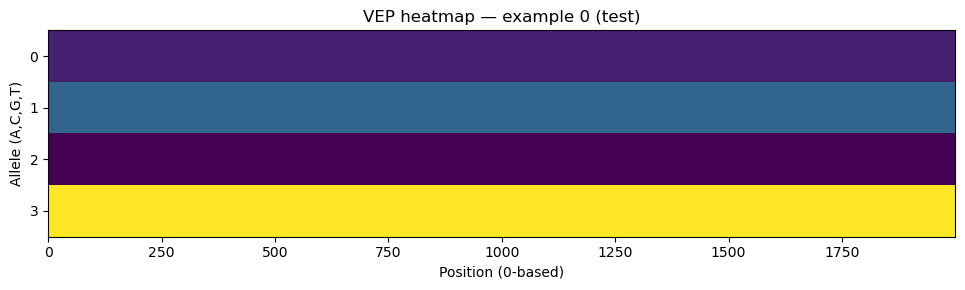

In [47]:
import numpy as np
import matplotlib.pyplot as plt

npz_path = VEP / f'deltas_{SPLIT}.npz'
if not npz_path.exists():
    raise FileNotFoundError(f'Missing {npz_path}. Run 04_variant_effects.ipynb first.')

arr = np.load(npz_path)['deltas']
print('Loaded deltas:', arr.shape)

ex = 0
D = arr[ex]
fig = plt.figure(figsize=(10,3))
plt.imshow(D.T, aspect='auto', interpolation='nearest')
plt.xlabel('Position (0-based)')
plt.ylabel('Allele (A,C,G,T)')
plt.title(f'VEP heatmap — example {ex} ({SPLIT})')
fig.tight_layout(); fig.savefig(PLOTS / f'vep_heatmap_{SPLIT}.png', dpi=200); plt.show()

## 4) Top-K bar chart

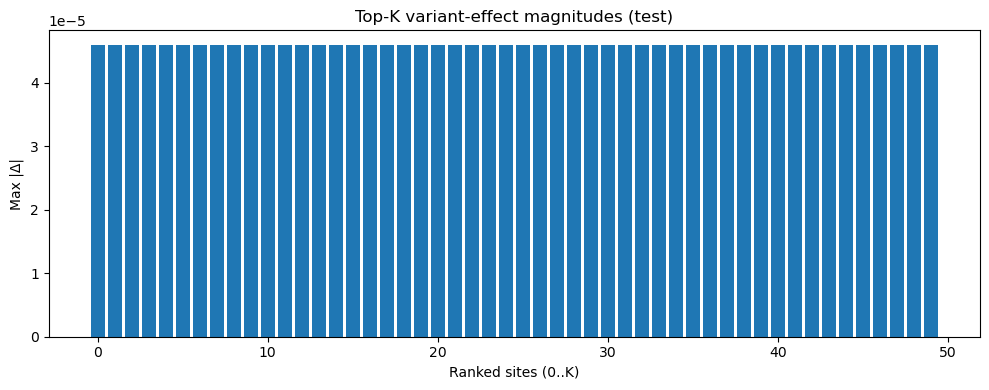

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

k_path = VEP / f'top50_{SPLIT}.tsv'
if k_path.exists():
    topk = pd.read_csv(k_path, sep='\t')
    fig = plt.figure(figsize=(10,4))
    vals = topk['max_abs_delta'].values[:50]
    x = np.arange(len(vals))
    plt.bar(x, vals)
    plt.xlabel('Ranked sites (0..K)')
    plt.ylabel('Max |Δ|')
    plt.title(f'Top-K variant-effect magnitudes ({SPLIT})')
    fig.tight_layout(); fig.savefig(PLOTS / f'topk_bar_{SPLIT}.png', dpi=200); plt.show()
else:
    print('No top-K TSV found at', k_path)

## 5) Figure manifest for LaTeX report

In [49]:
manifest = [
    str(PLOTS / 'metrics_bar_auroc.png'),
    str(PLOTS / 'metrics_bar_prauc.png'),
    str(PLOTS / f'vep_heatmap_{SPLIT}.png'),
    str(PLOTS / f'topk_bar_{SPLIT}.png'),
]
for p in manifest:
    print(p)

snippet = (
    '% Auto-generated figure paths\n'
    '\\newcommand{\\figAUROC}{' + str(PLOTS / 'metrics_bar_auroc.png') + '}\n'
    '\\newcommand{\\figPRAUC}{' + str(PLOTS / 'metrics_bar_prauc.png') + '}\n'
    '\\newcommand{\\figVEP}{' + str(PLOTS / f'vep_heatmap_{SPLIT}.png') + '}\n'
    '\\newcommand{\\figTOPK}{' + str(PLOTS / f'topk_bar_{SPLIT}.png') + '}\n'
)
with open(PLOTS / 'latex_commands.tex', 'w') as f:
    f.write(snippet)
print('LaTeX helper written to', PLOTS / 'latex_commands.tex')

results/plots/metrics_bar_auroc.png
results/plots/metrics_bar_prauc.png
results/plots/vep_heatmap_test.png
results/plots/topk_bar_test.png
LaTeX helper written to results/plots/latex_commands.tex
